# Session 4 Exercises
These are sample answers for the in-class exercises in Session 4 of PHAS0030.  You should make sure that you can do these yourself ! The further work exercises will be in a separate notebook.

In [1]:
# We always start with appropriate imports; note the use of the IPython magic
# command to set up Matplotlib within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 4. Euler's method

### Question 1

In [2]:
# Specify step size and simulation length
dx = 0.5
total_x = 20
N = int(total_x/dx)
x = np.linspace(0,total_x,N+1) # Store end point 
# Initial condition
y0 = 1.0
# Define k
k = 1.2
y = np.zeros(N+1)
y0 = 1.0
y[0] = y0
for i in range(N):
    y[i+1] = y[i]+dx*(-k*y[i])

Note that this is one occasion where we cannot use NumPy arrays or array commands to do the integration: it must be done explicitly with a loop (because each new step depends on the previous step).

Now we plot the approximate solution (`y`) and the exact (`exact_y`)

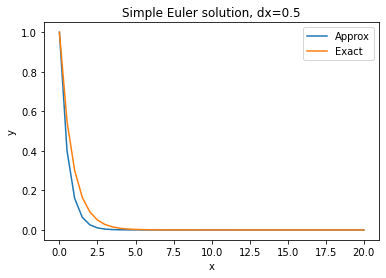

In [3]:
exact_y = y0*np.exp(-k*x)
plt.plot(x,y,label='Approx')
plt.plot(x,exact_y,label='Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Euler solution, dx=0.5')
plt.legend()

### Question 2

In [4]:
def fun_rhs(y,t):
    """RHS of simple first order ODE dy/dt = -ky
    Assumes k defined externally
    Inputs:
    t (unused)
    y
    Output:
    dy/dt"""
    return -k*y

In [5]:
def euler_solver(fun,y0,dt,N):
    """Solve dy/dt = fun(y,y) using Euler's method.
    Inputs:
    fun  f(y,t)
    y0   Initial condition
    dt   Step size
    N    Number of steps
    Returns: array of length N+1 with values of y
    """
    retval = np.zeros(N+1) # This stores y[i]
    retval[0] = y0
    t = 0
    for i in range(N):
        retval[i+1] = retval[i] + dt*fun(retval[i],t)
        t += dt
    return retval

Now we will change the step size.  First we reduce it to 0.1

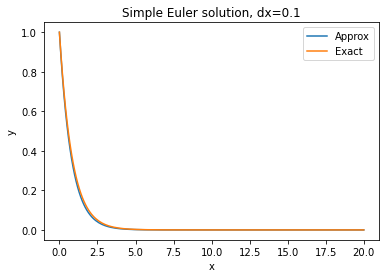

In [6]:
dx = 0.1
N = int(total_x/dx)
x = np.linspace(0,total_x,N+1) # Store end point 
y0 = 1.0
yp = euler_solver(fun_rhs,y0,dx,N)
plt.plot(x,yp,label='Approx')
plt.plot(x,y0*np.exp(-k*x),label='Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Euler solution, dx=0.1')
plt.legend()

This produces excellent agreement with the analytic solution.

Let's increase the step size to 1.0

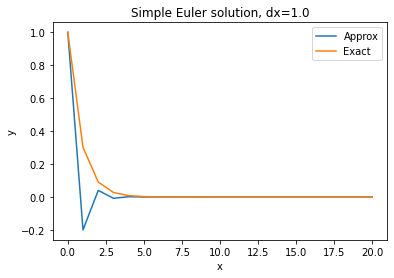

In [7]:
dx = 1.0
N = int(total_x/dx)
x = np.linspace(0,total_x,N+1) # Store end point 
y0 = 1.0
yp = euler_solver(fun_rhs,y0,dx,N)
plt.plot(x,yp,label='Approx')
plt.plot(x,y0*np.exp(-k*x),label='Exact')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Euler solution, dx=1.0')
plt.legend()

This is a very poor solution! We see that the effect of $\Delta x$ is exactly as in the notes: once $k\Delta x>1$ we get oscillatory and/or growing solutions.  For this system, a value around 0.1 gives a reasonable accuracy compared to the exact solution.  We can always check for accuracy by reducing the step size: we should see convergence towards the solution.

## 4.3 Beyond first order

### Question 1

Now we update the Euler solver to account for more than one dimension (effectively also allowing for solving higher order equations).  Note that I've chosen to allow an arbitrary size vector y; it would be fine to code this for the simple two component situation that we will be dealing with.

In [8]:
def euler_solver(fun,y0,dt,N):
    """Solve dy/dt = fun(y,t) using Euler's method.
    Inputs:
    fun  f(t,y)
    y0   Initial condition
    dt   Step size
    N    Number of steps
    Returns: array of length N+1 with values of y
    """
    # Note that np.size will work with single numbers and arrays
    # Choose 1D or multi-dimensional array
    size_of_y = np.size(y0)
    if size_of_y == 1:
        retval = np.zeros(N+1)
    else:
        retval = np.zeros((N+1,size_of_y))
    retval[0] = y0
    t = 0
    for i in range(N):
        retval[i+1] = retval[i] + dt*fun(retval[i],t)
        t += dt
    return retval

### Question 2

We need to define the function (RHS of the equation) and then call it.  Note that `motion[:,0]` gives the x value for all time steps (time is the first index in the array).

In [9]:
def RHS_SHO(y,t):
    """Return acceleration of SHO, defines k & m internally"""
    k = 1.0
    m = 1.0
    x = y[0]
    v = y[1]
    dx = v
    dv = -k*x/m
    return np.array([dx,dv])

Text(0.5, 1.0, 'SHO motion from Euler solver, dt=0.01')

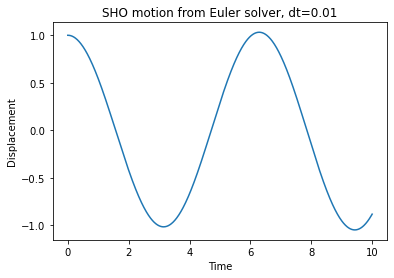

In [10]:
# Set up initial conditions
y0 = [1.0,0.0]
dt = 0.01
N = 1000
t_arr = np.linspace(0,N*dt,N+1)

# Solve ODE
motion = euler_solver(RHS_SHO,y0,dt,N)

# Plot solution
plt.plot(t_arr,motion[:,0])
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title(f'SHO motion from Euler solver, dt={dt}')

Note that a larger step size (I started with 0.1) gives an unstable solution which grows with time, as shown below.

Text(0.5, 1.0, 'SHO motion from Euler solver, dt=0.1')

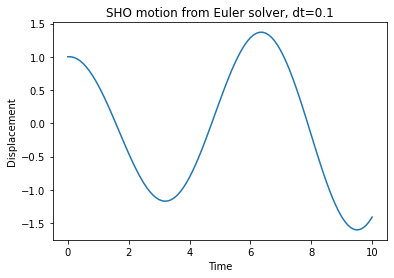

In [11]:
y0 = [1.0,0.0]
dt_large = 0.1
N = 100
motion_dt_large = euler_solver(RHS_SHO,y0,dt_large,N)
plt.plot(np.linspace(0,N*dt_large,N+1),motion_dt_large[:,0])
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title(f'SHO motion from Euler solver, dt={dt_large}')

## 5. Beyond Euler

### Question 1

In [12]:
def RK4_solver(fun,y0,dt,N):
    """Solve dy/dt = fun(y,t) using fourth-order RK method.
    Inputs:
    fun  f(y,t)
    y0   Initial condition - assumed to be two-component
    dt   Step size
    N    Number of steps
    Returns: two arrays of length N+1 (x and v or equivalent)
    """
    # Storage for solution
    y = np.zeros((N+1,2))
    # Initial condition
    y[0] = y0
    t = 0
    for i in range(N):
        # RK4 formulae
        k1 = dt*fun(y[i],t)
        k2 = dt*fun(y[i]+0.5*k1,t+0.5*dt)
        k3 = dt*fun(y[i]+0.5*k2,t+0.5*dt)
        k4 = dt*fun(y[i]+k3,t+dt)
        y[i+1]=y[i]+(k1+2*k2+2*k3+k4)/6
        t += dt
    return y

### Question 2

In [13]:
def RHS_linear_pendulum(y,t):
    """Implements linear pendulum RHS for ODE solver
    
    Inputs:
    y_n   2D vector containing theta and omega
    t     Time (unused)
    
    Output:
    dy_n  2D vector containing gradients dtheta and domega
    """
    g = 9.8
    L = 1.0
    # Separate for clarity
    theta = y[0]
    omega = y[1]
    dtheta = omega
    domega = -g*theta/L
    return np.array([dtheta,domega])

Text(0.5, 1.0, 'Pendulum small-angle solution')

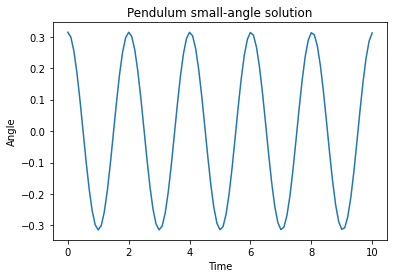

In [14]:
dt = 0.1
total_t = 10
N = int(total_t/dt)
# Initial conditions: 0.1pi radians is "small"
y0 = [0.1*np.pi,0.0]
lin_p = RK4_solver(RHS_linear_pendulum,y0,dt,N)
t = np.linspace(0,total_t,N+1)
plt.plot(t,lin_p[:,0])
plt.xlabel("Time")
plt.ylabel("Angle")
plt.title("Pendulum small-angle solution")

This has the expected period ($T = 2\pi/\omega$ with $\omega = \sqrt{g/L}$). 

I found that $\Delta t = 0.1$ gives a stable solution (roughly 10 times larger than Euler - for only four times the cost).

## 6. Boundary value problems

### Question 1

First define the right-hand side for the projectile.  The equation of motion for the height of the ball, $z$, is:
$$m\frac{d^2 z}{dt^2} = -mg$$
We split this second order ODE into two linked first order ODEs:
$$\frac{dz}{dt} = v$$

$$\frac{dv}{dt} = -g$$

In [15]:
def ball_vertical_RHS(y,t):
    """Calculate RHS for projectile ODE"""
    x = y[0]
    v = y[1]
    dx = v
    dv = -g # Gravity acts downwards
    return np.array([dx,dv])

Now for a given initial velocity we can find the resulting final height using the RK4 solver.  We then make a simple secant solver to find the appropriate starting velocity to give us the desired final boundary condition.

In [16]:
# Set up constants and parameters
g  = 9.81 # m/s^2
t0 = 0.0  # s
t1 = 10.0 # s
dt = 0.05 # s
N  = int((t1-t0)/dt)

# Initial guesses; I played around to find these
v_guess_1 = 0   # m/s
v_guess_2 = 200 # m/s

# Solve for first two height arrays - v doesn't need to be stored
traj1 = RK4_solver(ball_vertical_RHS,[0.0,v_guess_1],dt,N)
h1 = traj1[N,0]
traj2 = RK4_solver(ball_vertical_RHS,[0.0,v_guess_2],dt,N)
h2 = traj2[N,0]

# Seek to make the final height zero
tol = 1e-4
err = abs(h2)
while err > tol:
    # Secant update
    v_new = v_guess_2 - h2*(v_guess_2 - v_guess_1)/(h2 - h1)
    v_guess_1 = v_guess_2
    v_guess_2 = v_new
    h1 = h2
    traj2 = RK4_solver(ball_vertical_RHS,[0.0,v_guess_2],dt,N)
    h2 = traj2[N,0]
    err = abs(h2)
print("Initial velocity required is ",v_new)

Initial velocity required is  49.04999999999987


Text(0.5, 1.0, 'Trajectory of projectile')

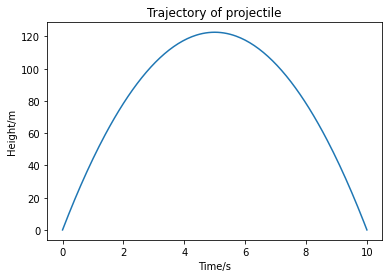

In [17]:
plt.plot(np.arange(t0,t1+0.5*dt,dt),traj2[:,0])
plt.xlabel('Time/s')
plt.ylabel('Height/m')
plt.title('Trajectory of projectile')

### Question 2

In [18]:
g  = 9.81 # m/s^2
t0 = 0.0  # s
t1 = 10.0 # s
dt = 0.05 # s
N  = int((t1-t0)/dt)
v_guess_1 = 0   # m/s
v_guess_2 = 200 # m/s

store = []
traj1 = RK4_solver(ball_vertical_RHS,[0.0,v_guess_1],dt,N)
h1 = traj1[N,0]
store.append(traj1[:,0])
traj2 = RK4_solver(ball_vertical_RHS,[0.0,v_guess_2],dt,N)
h2 = traj2[N,0]
store.append(traj2[:,0])
tol = 1e-4
err = abs(h2)
while err > tol:
    v_new = v_guess_2 - h2*(v_guess_2 - v_guess_1)/(h2 - h1)
    v_guess_1 = v_guess_2
    v_guess_2 = v_new
    h1 = h2
    traj2 = RK4_solver(ball_vertical_RHS,[0.0,v_guess_2],dt,N)
    h2 = traj2[N,0]
    err = abs(h2)
    store.append(traj2[:,0])
print("Initial velocity required is ",v_new)

Initial velocity required is  49.04999999999987


Text(0.5, 1.0, 'Trajectories of projectile during BVP solution')

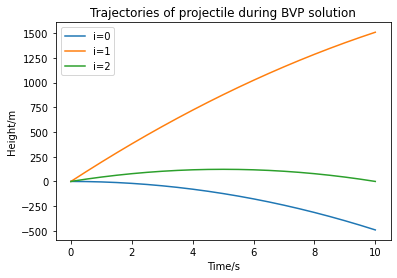

In [19]:
t = np.arange(t0,t1+0.5*dt,dt)
for i, traj in enumerate(store):
    plt.plot(t,traj,label=f'i={i}')
plt.xlabel('Time/s')
plt.ylabel('Height/m')
plt.legend()
plt.title('Trajectories of projectile during BVP solution')

## 7. SciPy functions

### Question 1

In [20]:
from scipy import integrate

In [21]:
def RHS_linear_pendulum_scipy(t,y):
    """Implements linear pendulum RHS for ODE solver
    
    Note that this is intended to be passed to solve_ivp from
    SciPy's integrate module, so needs the argument order t, y
    """
    g = 9.8
    L = 1.0
    theta = y[0]
    omega = y[1]
    dtheta = omega
    domega = -g*theta/L
    return np.array([dtheta,domega])

In [22]:
y0 = np.array([0.1*np.pi,0.0])
tspan = (0,10)
sp_solve = integrate.solve_ivp(RHS_linear_pendulum_scipy,tspan,y0)

Text(0.5, 1.0, 'Path of pendulum from solve_ivp')

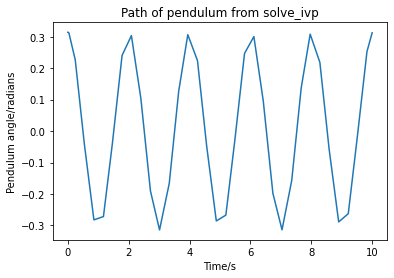

In [23]:
plt.plot(sp_solve.t,sp_solve.y[0])
plt.xlabel('Time/s')
plt.ylabel('Pendulum angle/radians')
plt.title('Path of pendulum from solve_ivp')

Notice how the solver has chosen the points at which to evaluate the solution: this gives us a rather poor quality plot.  We can define an array of times at which to solve rather easily.

Text(0.5, 1.0, 'Path of pendulum from solve_ivp')

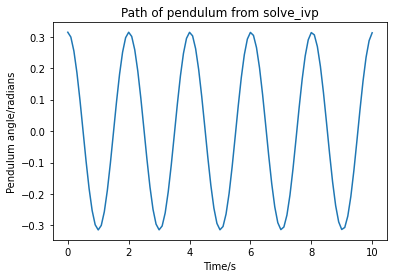

In [24]:
t = np.linspace(0,10,101)
sp_solve = integrate.solve_ivp(RHS_linear_pendulum_scipy,tspan,y0,t_eval=t)
plt.plot(sp_solve.t,sp_solve.y[0])
plt.xlabel('Time/s')
plt.ylabel('Pendulum angle/radians')
plt.title('Path of pendulum from solve_ivp')

This is much smoother.

The alternative solver requires a set of times, so we will use the same array.

In [25]:
ode_solve = integrate.odeint(RHS_linear_pendulum,y0,t)

Text(0.5, 1.0, 'Path of pendulum from odeint')

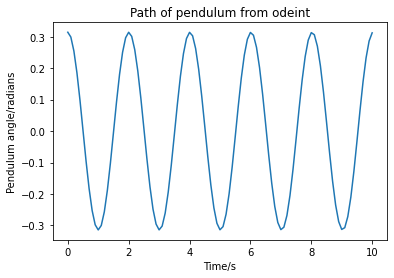

In [26]:
plt.plot(t,ode_solve[:,0])
plt.xlabel('Time/s')
plt.ylabel('Pendulum angle/radians')
plt.title('Path of pendulum from odeint')